<a href="https://colab.research.google.com/github/evanscastonguay/simulator/blob/main/simulator_tecl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2021-09-30, BUY CREATED  --- Price: 56.64, Size: 61, Cash: 10000.00
2021-10-01, BUY EXECUTED --- Price: 57.22, Value: 3490.42, Commission: 10.00


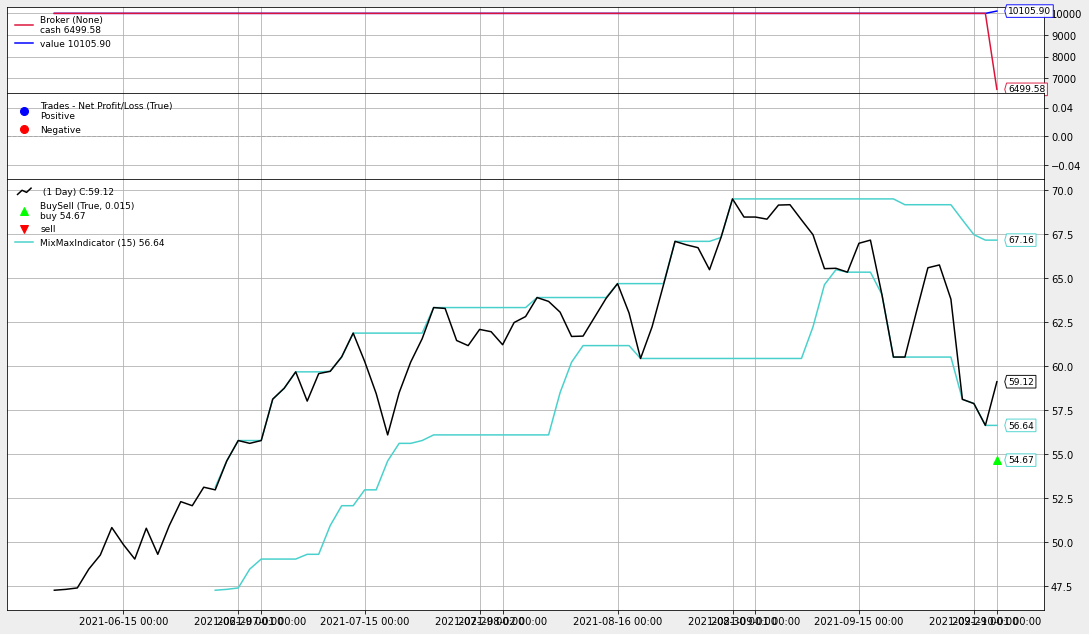

10105.89986038208

In [ ]:
!pip install backtrader[plotting]
!pip install yfinance

import matplotlib.pyplot as plt
import pandas as pd 
import yfinance as yf
import backtrader as bt
import backtrader.feeds as btfeeds
import random
import math
import smtplib, ssl 
import datetime as dat
from datetime import date 
from pylab import rcParams
rcParams['figure.figsize'] = 16,9
rcParams['figure.facecolor'] = '#eeeeee'

# Use a commission scheme that charge 10$ on every transaction
class FixedCommisionScheme(bt.CommInfoBase):
    params = ( ('commission', 10), ('stocklike', True), ('commtype', bt.CommInfoBase.COMM_FIXED), )
    def _getcommission(self, size, price, pseudoexec):
        return self.p.commission

# Use MixMaxIndicator to represent the mix and max trailing period  
class MixMaxIndicator(bt.Indicator):
  alias     = ('MMI', 'MixMaxIndicator',)
  lines     = ('min', 'max',) 
  params    = dict(trailing_period=20)
  plotinfo  = dict(subplot=False)                 # indicator along with data
  plotlines = dict( min=dict(_samecolor=True), max=dict(_samecolor=True),)   # use same color as prev line (max)
  def __init__(self):
    self.lines.min = bt.ind.Lowest (self.data.close,  period=self.p.trailing_period)
    self.lines.max = bt.ind.Highest(self.data.close,  period=self.p.trailing_period)


# RatioSizer control the size of the buy and sell
# buy_ratio represent the percentage of available cash that we are ready to buy
# sell_ratio represent the percentage of current hold position that we are ready to sell
class RatioSizer(bt.Sizer):
  params = (('buy_ratio', 1), ('sell_ratio', 1) )
  def _getsizing(self, comminfo, cash, data, isbuy):
    if isbuy :
      self.broker.getcash() 
      proposed_size = math.floor((self.broker.getcash() * self.p.buy_ratio ) / data.close)
    else :
      proposed_size = math.floor(self.position.size* sell_ratio)
    return proposed_size


class MixMaxStrategy(bt.Strategy):
  params = dict( ticker="TECL", trailing_period=15, best_gain_threshold = 0, worst_lost_threshold = -15,  sell_profit_threshold = 1, max_buy_value = 500000, log_enable = True, email_enable = True)

  def __init__(self):
    self.min_max_ind = MixMaxIndicator(trailing_period = self.p.trailing_period)
    self.order = None

  def log(self, txt):
    dt = self.datas[0].datetime.date(0).isoformat()
    if self.p.log_enable :
      print(f'{dt}, {txt}') 

  def is_datapoint_recent (self):
    is_datapoint_recent = False
    current_datapoint_date = self.datas[0].datetime.date(0)
    date_treshold = date.today() - dat.timedelta(days=5)
    print(f'current_datapoint_date: {current_datapoint_date} date_treshold:{date_treshold}')
    
    if current_datapoint_date > date_treshold:
      is_datapoint_recent = True
      
    return is_datapoint_recent
      
  
  def send_email (self, size, price_limit, order_date):
    total_price = size * price_limit
    if self.p.email_enable :
      print(f'send email: BUY {size} stock of {self.p.ticker} with price_limit of {price_limit:.2f} for a total amount of {total_price:.2f} on date: {order_date}.')
      port = 465  # For SSL
      smtp_server = "smtp.gmail.com"
      sender_email = "castonguayevans691@gmail.com" 
      receiver_email = "evans.castonguay@cerence.com"  
      password = ""
      message = f"""\
Subject: REMINDER SUBMIT BUY {size} stock of '{self.p.ticker}' with price_limit of {price_limit:.2f} for a total amount of {total_price:.2f} on date: {order_date}.

SUBMIT BUY ORDER of {size} {self.p.ticker} stock with a price_limit of {price_limit:.2f} for a total amount of {total_price:.2f} on date: {order_date}.
https://tmw.secure.vmd.ca/s9web/secure/orders/trade/stocks?symbol={self.p.ticker}-U&action=TRADE&side=BUY

See COLAB GRAPH: https://colab.research.google.com/drive/1kndxhlqA-KlNWkWsNmc8h0Bs5GJTJN7p#scrollTo=BSwvMDJWEJAU
See YAHOO GRAPH: https://finance.yahoo.com/chart/{self.p.ticker}#eyJpbnRlcnZhbCI6NSwicGVyaW9kaWNpdHkiOjEsInRpbWVVbml0IjoibWludXRlIiwiY2FuZGxlV2lkdGgiOjcuMjQyMjY4MDQxMjM3MTEzLCJmbGlwcGVkIjpmYWxzZSwidm9sdW1lVW5kZXJsYXkiOnRydWUsImFkaiI6dHJ1ZSwiY3Jvc3NoYWlyIjp0cnVlLCJjaGFydFR5cGUiOiJsaW5lIiwiZXh0ZW5kZWQiOmZhbHNlLCJtYXJrZXRTZXNzaW9ucyI6e30sImFnZ3JlZ2F0aW9uVHlwZSI6Im9obGMiLCJjaGFydFNjYWxlIjoibGluZWFyIiwicGFuZWxzIjp7ImNoYXJ0Ijp7InBlcmNlbnQiOjEsImRpc3BsYXkiOiJURUNMIiwiY2hhcnROYW1lIjoiY2hhcnQiLCJpbmRleCI6MCwieUF4aXMiOnsibmFtZSI6ImNoYXJ0IiwicG9zaXRpb24iOm51bGx9LCJ5YXhpc0xIUyI6W10sInlheGlzUkhTIjpbImNoYXJ0Iiwi4oCMdm9sIHVuZHLigIwiXX19LCJzZXRTcGFuIjp7Im11bHRpcGxpZXIiOjUsImJhc2UiOiJkYXkiLCJwZXJpb2RpY2l0eSI6eyJpbnRlcnZhbCI6NSwicGVyaW9kIjoxLCJ0aW1lVW5pdCI6Im1pbnV0ZSJ9LCJtYWludGFpblBlcmlvZGljaXR5Ijp0cnVlLCJmb3JjZUxvYWQiOnRydWV9LCJsaW5lV2lkdGgiOjIsInN0cmlwZWRCYWNrZ3JvdW5kIjp0cnVlLCJldmVudHMiOnRydWUsImNvbG9yIjoiIzAwODFmMiIsInN0cmlwZWRCYWNrZ3JvdWQiOnRydWUsImV2ZW50TWFwIjp7ImNvcnBvcmF0ZSI6eyJkaXZzIjp0cnVlLCJzcGxpdHMiOnRydWV9LCJzaWdEZXYiOnt9fSwiY3VzdG9tUmFuZ2UiOm51bGwsInN5bWJvbHMiOlt7InN5bWJvbCI6IlRFQ0wiLCJzeW1ib2xPYmplY3QiOnsic3ltYm9sIjoiVEVDTCIsInF1b3RlVHlwZSI6IkVURiIsImV4Y2hhbmdlVGltZVpvbmUiOiJBbWVyaWNhL05ld19Zb3JrIn0sInBlcmlvZGljaXR5IjoxLCJpbnRlcnZhbCI6NSwidGltZVVuaXQiOiJtaW51dGUiLCJzZXRTcGFuIjp7Im11bHRpcGxpZXIiOjUsImJhc2UiOiJkYXkiLCJwZXJpb2RpY2l0eSI6eyJpbnRlcnZhbCI6NSwicGVyaW9kIjoxLCJ0aW1lVW5pdCI6Im1pbnV0ZSJ9LCJtYWludGFpblBlcmlvZGljaXR5Ijp0cnVlLCJmb3JjZUxvYWQiOnRydWV9fV0sInN0dWRpZXMiOnsi4oCMdm9sIHVuZHLigIwiOnsidHlwZSI6InZvbCB1bmRyIiwiaW5wdXRzIjp7ImlkIjoi4oCMdm9sIHVuZHLigIwiLCJkaXNwbGF5Ijoi4oCMdm9sIHVuZHLigIwifSwib3V0cHV0cyI6eyJVcCBWb2x1bWUiOiIjMDBiMDYxIiwiRG93biBWb2x1bWUiOiIjZmYzMzNhIn0sInBhbmVsIjoiY2hhcnQiLCJwYXJhbWV0ZXJzIjp7IndpZHRoRmFjdG9yIjowLjQ1LCJjaGFydE5hbWUiOiJjaGFydCIsInBhbmVsTmFtZSI6ImNoYXJ0In19fX0-

"""
      context = ssl.create_default_context()
      with smtplib.SMTP_SSL(smtp_server, port, context=context) as server:
        server.login(sender_email, password)
        server.sendmail(sender_email, receiver_email, message)
    return

  def notify_order(self, order):
    if order.status in [order.Submitted, order.Accepted]:
      return

    if order.status in [order.Completed]:
      if order.isbuy():
        self.log( f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Value: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}' )
      else:
        self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Value: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}')

    elif order.status in [order.Canceled, order.Margin, order.Rejected]:
      self.log('Order Failed')
    self.order = None   

  def notify_trade(self, trade):
    if not trade.isclosed:
      return
    self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

  def next(self): 
    if self.order: # check if order is pending, if so, skip to let the order execute
      return
    # get min and max value for the period 
    min = self.min_max_ind.min[0]
    max = self.min_max_ind.max[0]   
         
    # worst_lost - representage the worst lost percentage during that period that range between [-100,0] 
    #     Example: -15 would mean that if you bought the stock at the worst time you will have lost 15% of your investment. 
    #              -100 = you lost it all      
    worst_lost = ((self.data_close[0] - max) * 100 / max )

    # best_gain - represent the best gain percentage during that period that range between [0, 100+]
    #     Example: 20 would mean that if you bought the stock at the best time you will have gain 20% of your investment
    best_gain  = ((self.data_close[0] - min) * 100 / min )

    target_worst_lost_price = max * ((100 + self.p.worst_lost_threshold)/100)
    target_best_gain_price = min + (min * (self.p.best_gain_threshold /100))
    target_price = target_best_gain_price
    if target_worst_lost_price < target_best_gain_price :
      target_price = target_worst_lost_price

    if self.is_datapoint_recent() :
      self.log(f'{self.p.ticker} - CLOSE_PRICE: {self.data_close[0]:.2f}, TARGET_PRICE: {target_price:.2f}, TARGET_WORST_LOST:{target_worst_lost_price:.2f}, TARGET_BEST_GAIN:{target_best_gain_price:.2f}')

    # if the worst_lost is smaller than the worst_lost_threshold it means that the stock is at a discount and 
    # if the best_gain is smaller than the best gain treshold it means that the stock is at a discount
    if  ((worst_lost <= self.p.worst_lost_threshold) and ( best_gain <= self.p.best_gain_threshold ) ) :
      self.order = self.buy()
      if self.order :
        self.log(f'BUY CREATED  --- Price: {self.data_close[0]:.2f}, Size: {self.order.size}, Cash: {self.broker.getcash():.2f}')
        if self.is_datapoint_recent() :
          self.send_email (self.order.size, self.data_close[0] , self.datas[0].datetime.date(0).isoformat())
    elif self.position: # in the market
      # calculate potential profit percentage
      position_profit = (self.data_close[0] - self.position.price) / self.position.price 
      # if it is bigger than sell_profit_threshold
      if (position_profit > self.p.sell_profit_threshold) : 
        self.order = self.sell(size = self.position.size)
        self.log(f'SELL CREATED  --- Price: {self.data_close[0]:.2f}, Size: {self.position.size}, Cash: {self.broker.getcash():.2f}, ')


def  runCerebro(ticker, startTime, endTime, trailing_period=15,  buy_ratio=.20, best_gain_threshold=0, worst_lost_threshold=-15,sell_profit_threshold=2, log_enable = True, plot_enable=False, email_enable = True) :
  df = yf.download(ticker,  start=startTime, end=endTime, progress=False)
  data = bt.feeds.PandasData(dataname=df)


  cerebro = bt.Cerebro()
  cerebro.addstrategy(MixMaxStrategy, 
                      ticker = ticker,
                      trailing_period=trailing_period, 
                      best_gain_threshold=best_gain_threshold, 
                      worst_lost_threshold=worst_lost_threshold,
                      sell_profit_threshold=sell_profit_threshold,
                      log_enable = log_enable,
                      email_enable = email_enable)
  cerebro.broker.setcash(10000)
  cerebro.broker.addcommissioninfo( FixedCommisionScheme() )
  cerebro.addsizer(RatioSizer, buy_ratio=buy_ratio)

  cerebro.adddata(data)
  cerebro.run()

  value = cerebro.broker.getvalue()
#  print("{},{},{},{},{},{},{},{},{}".format(ticker,startTime, endTime, value,trailing_period, buy_ratio, best_gain_threshold, worst_lost_threshold, sell_profit_threshold))

  if plot_enable :
    cerebro.plot(height= 30, iplot= False, volume = False)
  return value

runCerebro('TECL', '2021-06-06',date.today().strftime("%Y-%m-%d"), trailing_period=15, buy_ratio=.35, best_gain_threshold=0, worst_lost_threshold=-15,sell_profit_threshold=2, log_enable = True, plot_enable=True, email_enable = True)